In [11]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import astropy.units as u

# increase the font size
plt.rcParams.update({'font.size': 12})

flares = pd.read_csv("../results/flare_phases_and_energies.csv")

phases = flares.sort_values(by="ed_rec", ascending=True).phase.values[1:]

In [12]:

rstar = 1.0
aplanet = 11.7 # semi-major axis in units of rstar

# number of bins
nbins = 200

# longitude at t=0 of the dipole field axis
phi = np.linspace(0., 1, nbins)

# obliquity of dipole field axis
alphamax = 20 * np.pi/180

# resulting dipole field inclinations as a function of phi
alphas = (alphamax * np.cos(phi * 2 * np.pi))

def get_surface_latitudes(aplanet, alphas, rstar = 1):
  """
  Calculate the observed latitude of the dominant SPI spot on the star.


  Parameters
  ----------
  aplanet : float
    semi-major axis in units of rstar
  alphas : array-like
    array of projected dipole inclinations in radians

  """
  
  # calculate the dipole oval radius for each dipole inclination using the bioval
  reqs = np.array ([aplanet / (np.cos(a)**2) for a in alphas])

  # calc the latitude at rstar (=on stellar surface) using the bioval again 
  # then shift by current projected dipole field inclination to get observed latitude  
  lat =  np.arccos(np.sqrt(rstar / reqs)) - alphas
  # lat = np.concatenate((lat, lat))

  # interpolate to nbins
  # lat = np.interp(np.linspace(0, 1, nbins), np.linspace(0, 1, 2*nbins), lat)

  # if the latitude is larger than 90 degrees, the dominant spot switches to the second one
  lat = lat * 180 / np.pi
  lat[lat > 90] = - lat[lat > 90] + 180
  
  return  lat, lat > 90

# get surface longitude from latitude 
def get_surface_longitude(aplanet, phi, alphamax, rstar = 1, offset=0):
 
  phioff = phi + offset

  alphas = alphamax * np.cos(phioff * 2 * np.pi)
  lat, _ = get_surface_latitudes(aplanet, alphas, rstar=rstar)

  # calculate the longitude of the spot on the star
  co_alphas =  alphamax * np.sin(phioff * 2 * np.pi)

  lon = co_alphas * np.sin(lat * np.pi / 180) 

  # lon[lon<0] = lon[lon<0] + np.pi*2

  return lon



surfacelats, spot_flip = get_surface_latitudes(aplanet, alphas)

surfacelons = get_surface_longitude(aplanet, phi, alphamax)

(0.0, 1.0)

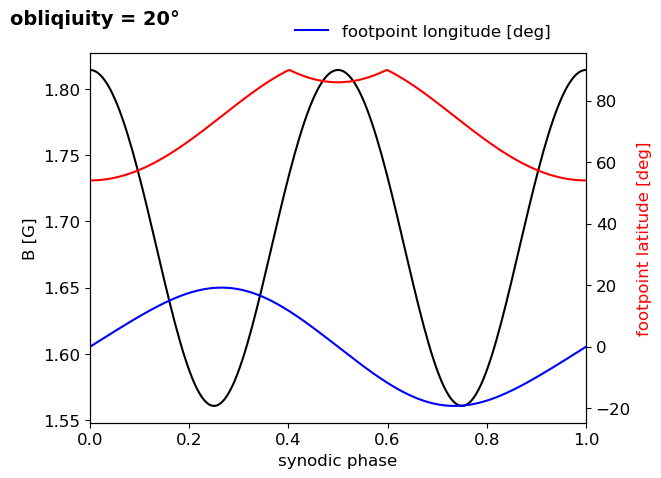

In [13]:
B_0 = 2500 # G

# field that the planet sees; strongest field at alpha=0
B = B_0 * (rstar / aplanet)**3 * np.sqrt(1 + 3*np.cos(alphas-np.pi/2)**2)

plt.figure()
plt.plot(phi, B  ,c="k")

plt.ylabel('B [G]')
plt.xlabel("synodic phase")
# add a dual axis
ax2 = plt.gca().twinx()
ax2.plot(phi, surfacelats , c='red')

# plt.plot(phi, alphas  , label='B [G]', c="g")
plt.plot(phi, surfacelons * 180/np.pi, c="b", label="footpoint longitude [deg]")

ax2.set_ylabel('footpoint latitude [deg]', color='red')


plt.legend(loc=(0.4, 1.02), frameon=False)

# text in the upper left corner of image with alphamax
plt.text(0.0,  0.94, rf'obliqiuity = {alphamax*180/np.pi:.0f}°', fontsize=14, transform=plt.gcf().transFigure, fontweight='bold')

plt.xlim(0,1)

# sanity checks:

# 1
# at 0. and 0.5 maximum B because the planet is closest to the pole of the dipole

# 2
# footpoint latitude is lowest at 0 and 1 because start off with the dipole axis pointing towards the planet

# 3
# footpoint longitude starts off at 0 and goes through 0 at 0.5 because this is where 
# the dipole has no azimuthal componentrelative to the planet

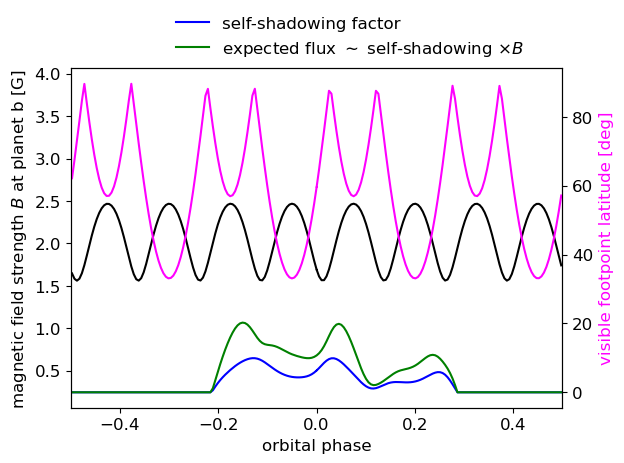

In [39]:
def get_modulation(alphamax, offset, syn_to_orb=4):

    # transform everything back into the observer frame
    # this is a factor of 4 for everything observed by the planet
    # because one full orbit equals 4 synodic orbits

    # one synodic orbit
    phi = np.linspace(0., 1, nbins)

    # magnetic field inclinations observed by the planet over one full orbit
    alphas = (alphamax * np.cos((phi + offset) * syn_to_orb * 2 * np.pi))

    # magnetic fields seen by the planet over one full orbit 
    # note the factor of 4 come from alpha
    B = B_0 * (rstar / aplanet)**3 * np.sqrt(1 + 3 * np.cos(alphas +np.pi/2)**2)

    # surface latitudes of the dominant spot observed by the planet over one full orbit
    # no change in latitude in the frame of reference shift only a shift
    # in how often the modulation is observed, i.e., 4 times
    surfacelats = get_surface_latitudes(aplanet, alphas)[0]

    # now transform the longitude in the planets reference frame to the observer frame
    # first get the longitude in the planets frame
    longitude_syn = get_surface_longitude(aplanet, phi*4, alphamax, offset=offset) 
    # then transform to the observer frame by adding it to the orbital phase phi
    longitude_obs = -longitude_syn / 2 / np.pi + phi 
    
    # foreshortening depends on the longitude and latitude seen by the observer
    # don't forget to convert both values to angles in radians
    foreshortening = np.abs(np.cos(longitude_obs * 2 * np.pi) * np.sin(surfacelats / 180 * np.pi))

    # longitudes on the back of the star are not observed
    phimask = ((longitude_obs % 1) > 0.25) & ((longitude_obs % 1) < 0.75)
    foreshortening[phimask] = 0

    return B, surfacelats, foreshortening, longitude_obs, longitude_syn

B, surfacelats, foreshortening, longitude_obs, longitude_syn = get_modulation(45 * np.pi /180, 0.3)

# offset phi such that transit is in the middle
phi_off = (phi + 0.5) % 1 - 0.5 

sorted_phi_args = np.argsort(phi_off)

phi_off = phi_off[sorted_phi_args]
B = B[sorted_phi_args]
surfacelats = surfacelats[sorted_phi_args]
foreshortening = foreshortening[sorted_phi_args]

# plot left axis --------------------------------------------------------------
plt.figure()
plt.plot(phi_off, B , c="k")
plt.ylabel('magnetic field strength $B$ at planet b [G]')
plt.xlabel("orbital phase")
plt.ylim(np.mean(B) - 2, np.mean(B) + 2)
# add a dual axis
ax2 = plt.gca().twinx()


# mask_lower_hem = surfacelats10 > 0

ax2.plot(phi_off, surfacelats, c='magenta')
ax2.plot(phi_off, foreshortening * 1e1 , 
           c='blue', label='self-shadowing factor' )

ax2.plot(phi_off, foreshortening * B * 10, 
           c='green',  label=r'expected flux $\sim$ self-shadowing $\times B$')

# plt.text(-0.01, 0.04, 'best-fit \nclustering', color='k', fontsize=12, transform=plt.gca().transAxes)
# plt.text(0.3, 0.04, 'planet \nin front\nof star', color='grey', fontsize=12, transform=plt.gca().transAxes)
plt.legend(loc=(0.2,1.01), frameon=False, fontsize=12)
# shade the region between 0.5 and 0.7
# plt.fill_between([0.5, 0.7], -190, 190, color='gray', alpha=0.6)
# plt.fill_between([0.25, 0.75], -190, 190, color='gray', alpha=0.2)
# plt.ylim(-120,120)


# plt.text(-0.1, 1.1, fr'mag. obl.={alphamax*180/np.pi:.0f}$^\circ$', transform=plt.gca().transAxes, fontsize=13)
# ax2.axhline(0, color='red', linestyle=':')
ax2.set_ylabel('visible footpoint latitude [deg]', color='magenta')
plt.xlim(-0.5, 0.5)

plt.tight_layout()
# plt.savefig('../plots/paper/toy_model.png', dpi=300)

43.79443649979272

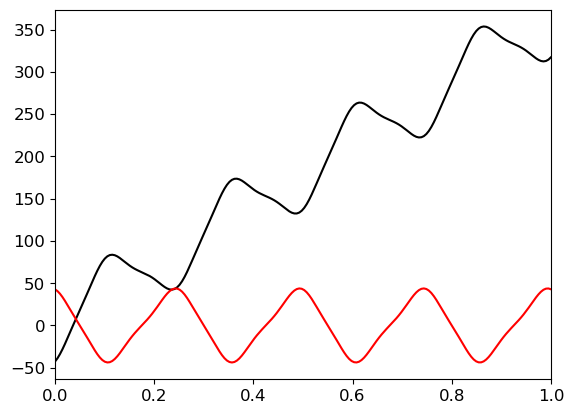

In [40]:
plt.plot(phi, longitude_obs * 360  , c="k")
plt.plot(phi, longitude_syn * 180 / np.pi, c="r")
plt.xlim (0,1)
max(longitude_syn*180/np.pi)

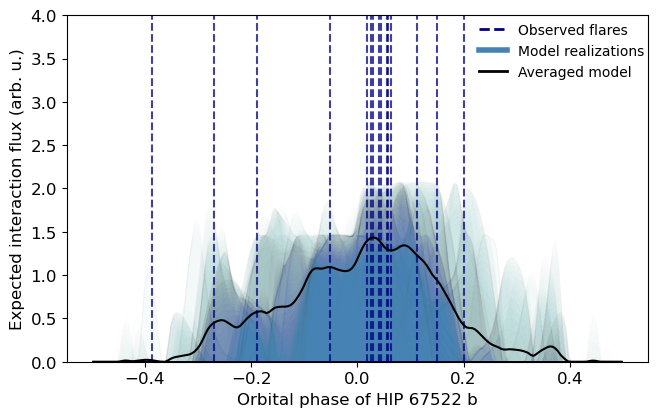

In [24]:
N1, N2 =30, 30
offs, amaxs = [], []

plt.figure(figsize=(7.5, 4.5))

fluxs = np.zeros_like(phi_off)
for a in np.linspace(0.01, 0.99, N1):
    alphamax = np.arccos(a)
    alphamax = alphamax % (np.pi/2)

    for offset in np.linspace(0.001, 1, N2):

        B, surfacelats, foreshortening, longitude_obs, longitude_syn = get_modulation(alphamax, offset)

        flux = B * foreshortening
        flux = flux[sorted_phi_args]
        maxphi_arg = np.argmax(flux)   
        maxphi = phi_off[maxphi_arg]
        maxflux = flux[maxphi_arg]
        


        if (maxphi > 0.0 and maxphi < .2) & (np.max(flux[:len(flux)//2 ]) <  0.9 * maxflux):
            # plt.plot(phi_off,  flux, c="k", alpha=0.01)
            plt.fill_between(phi_off, 0, flux, color='steelblue', alpha=0.008, edgecolor = "k")
            offs.append(offset)
            amaxs.append(alphamax)

            fluxs += flux
phases[phases>0.5] -= 1
for phase in phases:
    
    plt.axvline(phase, color='navy', linestyle='--', alpha=0.75)

plt.plot(phi_off, fluxs/len(offs), c="k")
plt.ylim(0, 4)
plt.xlabel("Orbital phase of HIP 67522 b")
plt.ylabel("Expected interaction flux (arb. u.)")

# add legend handles for the phases, flux, and averaged flux
custom_lines = [Line2D([0], [0], color='navy', linestyle='--', lw=2),
                Line2D([0], [0], color='steelblue', lw=4),
                Line2D([0], [0], color='k', lw=2),
                ]

plt.legend(custom_lines, ['Observed flares', 'Model realizations', 'Averaged model'], 
           loc=(0.7,0.8), frameon=False, fontsize=10)

plt.savefig('../plots/paper/toy_model_realizations.png', dpi=300)

0.24444444444444444


Text(0.5, 0, 'orbital phase offset')

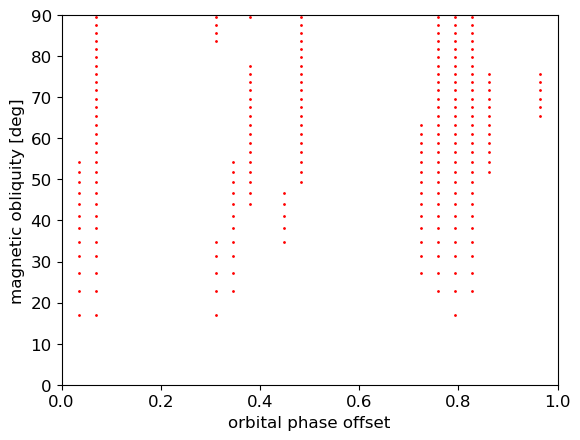

In [23]:
plt.scatter(offs, np.array(amaxs)*180/np.pi, c='r', s=1)
plt.xlim(0,1)
plt.ylim(0,90)
print(len(offs)/N1/N2)
plt.ylabel('magnetic obliquity [deg]')
plt.xlabel('orbital phase offset')